# Chicago Crime EDA (2015–2024) with Community Areas

This notebook performs **Stage 1 EDA** by combining Chicago crime records with community area boundaries to deliver temporal insights and spatial intelligence for resource allocation.

## 1. Setup
We import required libraries and set plotting styles for consistent, publication-quality visuals.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt
import textwrap

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


## 2. Load Crime Data Efficiently (2015–2024 only)
We read the crime CSV in chunks to avoid loading the full dataset. We **filter by year first** and then drop rows missing `Date` or `Community Area` to reduce work early. This order minimizes wasted cleaning on out-of-scope years.

In [2]:
CRIME_PATH = '/Users/liqinkai/Programs/it5006/IT5006-Group8/Crimes_-_2001_to_Present_20260203.csv'

crime_usecols = [
    'Date',
    'Primary Type',
    'Description',
    'Community Area',
    'Location Description',
    'Domestic',
    'Arrest'
]

chunks = []
chunksize = 500_000

for chunk in pd.read_csv(CRIME_PATH, usecols=crime_usecols, chunksize=chunksize):
    # Convert Date to datetime using known format; invalid parse -> NaT
    chunk['Date'] = pd.to_datetime(
        chunk['Date'],
        format='%m/%d/%Y %I:%M:%S %p',
        errors='coerce'
    )

    # Filter to 2015–2024 inclusive (drop out-of-scope years early)
    mask = (chunk['Date'].dt.year >= 2015) & (chunk['Date'].dt.year <= 2024)
    chunk = chunk.loc[mask].copy()

    # Drop rows missing Date or Community Area after filtering
    chunk = chunk.dropna(subset=['Date', 'Community Area'])

    chunks.append(chunk)

crime_df = pd.concat(chunks, ignore_index=True)

print(f'Loaded rows: {len(crime_df):,}')
print(crime_df.head())


Loaded rows: 2,519,279
                 Date       Primary Type  \
0 2024-12-31 23:58:00    CRIMINAL DAMAGE   
1 2024-12-31 23:56:00  CRIMINAL TRESPASS   
2 2024-12-31 23:55:00            BATTERY   
3 2024-12-31 23:53:00    CRIMINAL DAMAGE   
4 2024-12-31 23:50:00            BATTERY   

                                         Description Location Description  \
0                                        TO PROPERTY            APARTMENT   
1                                       TO RESIDENCE            APARTMENT   
2  AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...        HOTEL / MOTEL   
3                                         TO VEHICLE               STREET   
4                                             SIMPLE             SIDEWALK   

   Arrest  Domestic  Community Area  
0   False     False            43.0  
1    True      True            38.0  
2   False      True            70.0  
3   False     False            42.0  
4   False     False            25.0  


## 3. Load Community Area Boundaries
We load the boundary CSV and convert `the_geom` (WKT) into geometries for a GeoDataFrame. We also ensure `AREA_NUMBE` is integer to match the crime data.

In [3]:
BOUNDARY_PATH = 'Boundaries_-_Community_Areas_20260205.csv'

geo_df = pd.read_csv(BOUNDARY_PATH, usecols=['the_geom', 'AREA_NUMBE', 'COMMUNITY'])

# Convert WKT -> geometry, guarding against missing geometry
geo_df = geo_df.dropna(subset=['the_geom']).copy()
geo_df['geometry'] = geo_df['the_geom'].apply(wkt.loads)
geo_df = gpd.GeoDataFrame(geo_df, geometry='geometry', crs='EPSG:4326')

# Ensure AREA_NUMBE is int
geo_df['AREA_NUMBE'] = geo_df['AREA_NUMBE'].astype(int)

geo_df.head()


,the_geom,AREA_NUMBE,COMMUNITY,geometry
0,MULTIPOLYGON (((-87.65455590025104 41.99816614...,1,ROGERS PARK,"MULTIPOLYGON (((-87.65456 41.99817, -87.65574 ..."
1,MULTIPOLYGON (((-87.6846530946559 42.019484772...,2,WEST RIDGE,"MULTIPOLYGON (((-87.68465 42.01948, -87.68464 ..."
2,MULTIPOLYGON (((-87.64102430213292 41.95480280...,3,UPTOWN,"MULTIPOLYGON (((-87.64102 41.9548, -87.644 41...."
3,MULTIPOLYGON (((-87.6744075678037 41.976103404...,4,LINCOLN SQUARE,"MULTIPOLYGON (((-87.67441 41.9761, -87.6744 41..."
4,MULTIPOLYGON (((-87.67336415409336 41.93234274...,5,NORTH CENTER,"MULTIPOLYGON (((-87.67336 41.93234, -87.67342 ..."


## 4. Enrich Crime Data with Community Names
We map `Community Area` numbers to community names for human-readable analysis. We also coerce the community area column to integer **after dropping nulls** to avoid conversion warnings.

In [4]:
# Build mapping: AREA_NUMBE -> COMMUNITY
area_to_name = dict(zip(geo_df['AREA_NUMBE'], geo_df['COMMUNITY']))

# Ensure community area is integer (safe after dropping NaN)
crime_df['Community Area'] = crime_df['Community Area'].astype(int)
crime_df['Community_Name'] = crime_df['Community Area'].map(area_to_name)

# Convert text columns to category for memory efficiency
crime_df['Primary Type'] = crime_df['Primary Type'].astype('category')
crime_df['Description'] = crime_df['Description'].astype('category')
crime_df['Location Description'] = crime_df['Location Description'].astype('category')

crime_df.head()


,Date,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Community_Name
0,2024-12-31 23:58:00,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,43,SOUTH SHORE
1,2024-12-31 23:56:00,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,True,True,38,GRAND BOULEVARD
2,2024-12-31 23:55:00,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,False,True,70,ASHBURN
3,2024-12-31 23:53:00,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,42,WOODLAWN
4,2024-12-31 23:50:00,BATTERY,SIMPLE,SIDEWALK,False,False,25,AUSTIN


## 5. Feature Engineering for Time Analysis
We extract temporal features that enable trend analysis and pattern discovery.

In [5]:
crime_df['Year'] = crime_df['Date'].dt.year
crime_df['Month'] = crime_df['Date'].dt.month
crime_df['Day_of_Week'] = crime_df['Date'].dt.day_name()
crime_df['Hour'] = crime_df['Date'].dt.hour

crime_df.info(memory_usage='deep')


<class 'pandas.DataFrame'>
RangeIndex: 2519279 entries, 0 to 2519278
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Date                  datetime64[us]
 1   Primary Type          category      
 2   Description           category      
 3   Location Description  category      
 4   Arrest                bool          
 5   Domestic              bool          
 6   Community Area        int64         
 7   Community_Name        str           
 8   Year                  int32         
 9   Month                 int32         
 10  Day_of_Week           str           
 11  Hour                  int32         
dtypes: bool(2), category(3), datetime64[us](1), int32(3), int64(1), str(2)
memory usage: 167.3 MB


# Section A: Temporal Analysis
We analyze crime volume by month and time-of-week patterns to understand seasonality and time-based concentration.

## Plot 1: Monthly Crime Trend
This line plot highlights seasonality and monthly changes in crime volume.

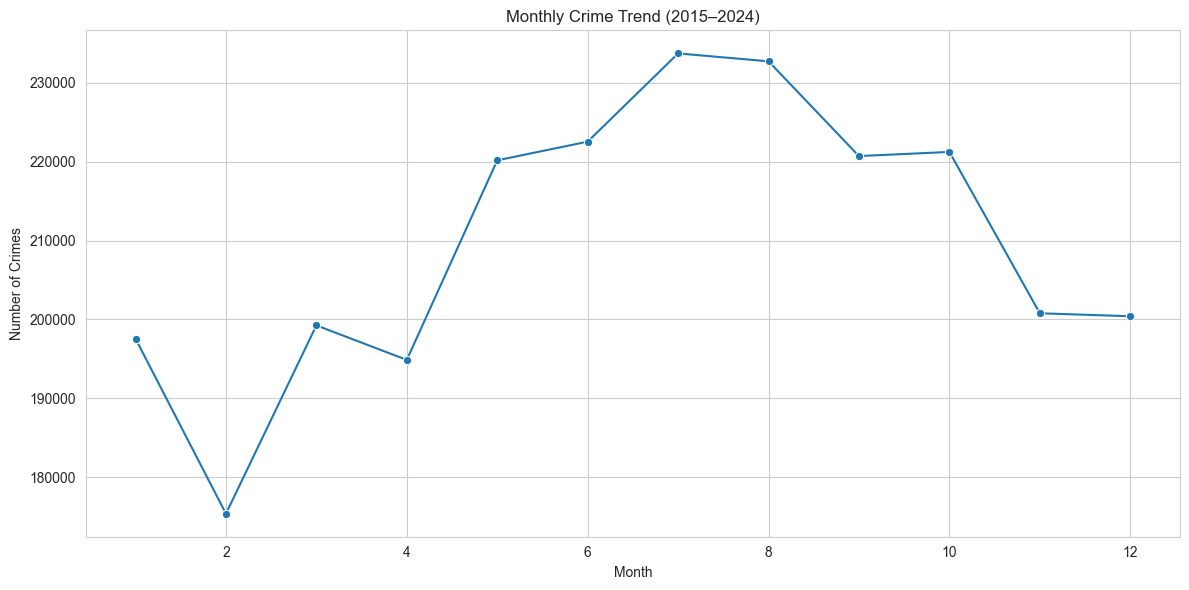

In [6]:
monthly_counts = crime_df.groupby('Month').size()

plt.figure()
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker='o')
plt.title('Monthly Crime Trend (2015–2024)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.show()


## Plot 2: Heatmap of Day of Week vs Hour
The heatmap reveals temporal hotspots by time-of-week, useful for optimizing patrol schedules.

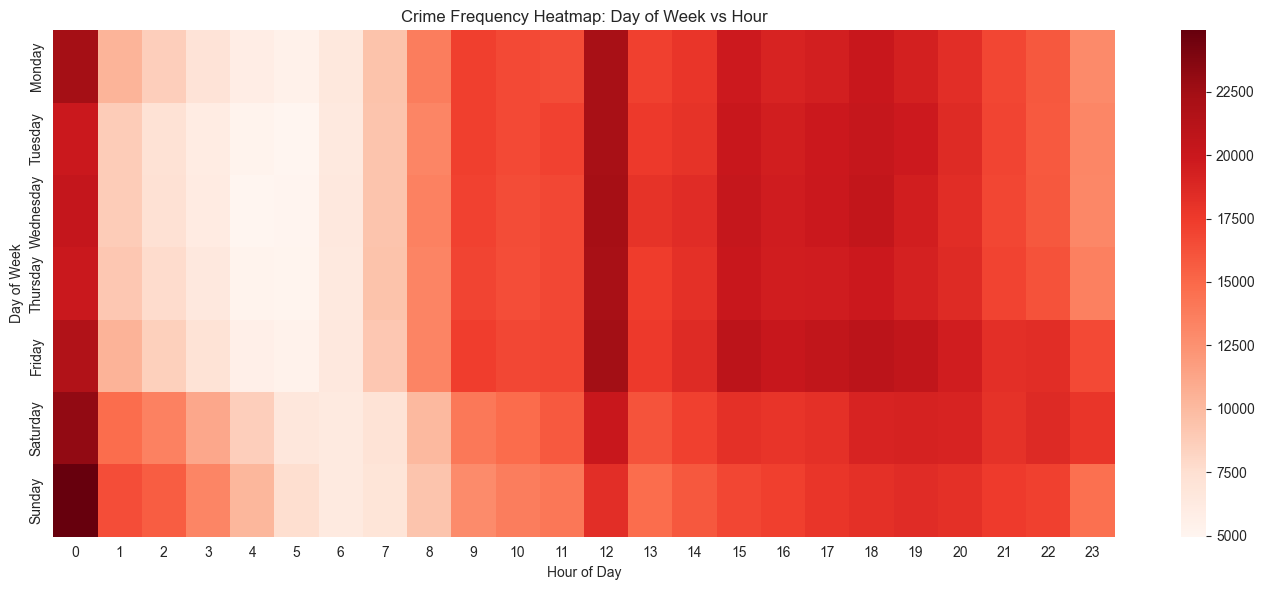

In [7]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

heatmap_data = (
    crime_df.groupby(['Day_of_Week', 'Hour'])
    .size()
    .unstack(fill_value=0)
    .reindex(day_order)
)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Reds')
plt.title('Crime Frequency Heatmap: Day of Week vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


# Section B: Spatial Analysis (The Wow Factor)
We aggregate crime counts by community area and visualize them on a choropleth map.

## Plot 3: Choropleth Map of Crime Density by Community Area
**Business Value:** This map identifies high-priority resource allocation zones, enabling targeted patrols and intervention planning.

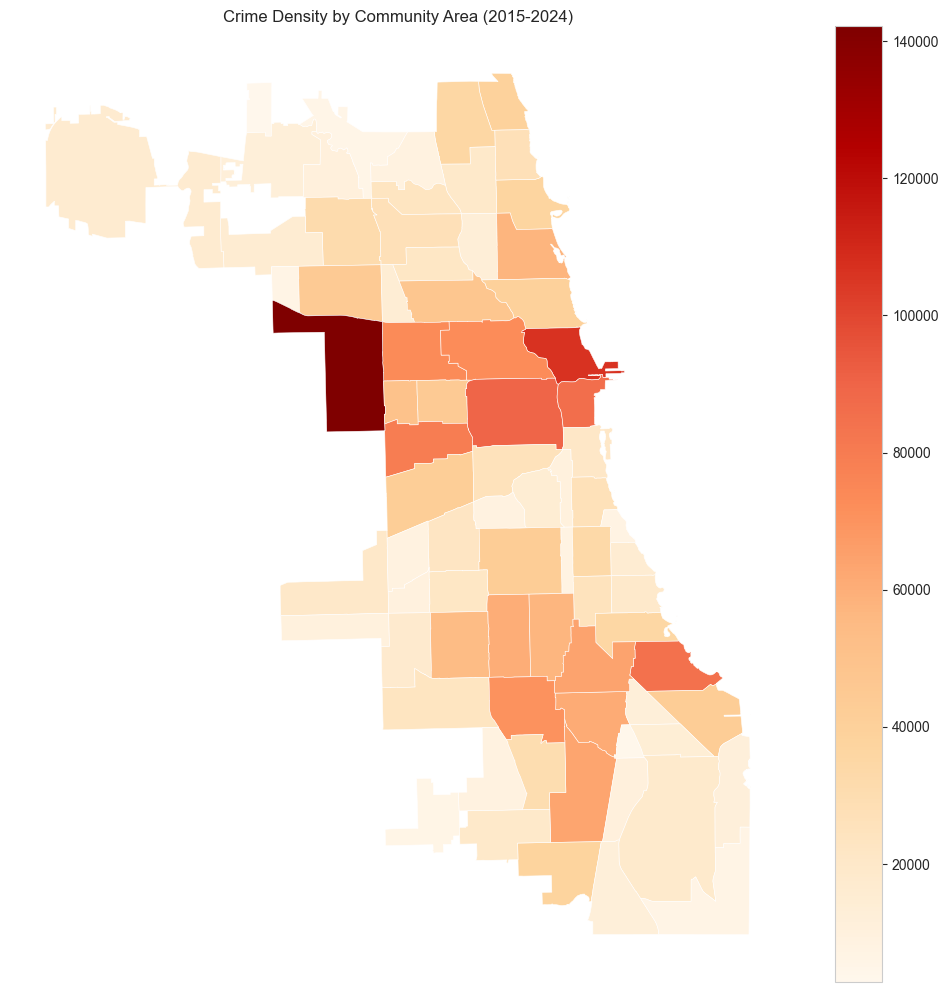

In [8]:
community_counts = crime_df.groupby('Community Area').size().reset_index(name='Crime_Count')

geo_merged = geo_df.merge(community_counts, left_on='AREA_NUMBE', right_on='Community Area', how='left')
geo_merged['Crime_Count'] = geo_merged['Crime_Count'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_merged.plot(column='Crime_Count', cmap='OrRd', linewidth=0.4, ax=ax, edgecolor='white', legend=True)
ax.set_title('Crime Density by Community Area (2015-2024)')
ax.axis('off')
plt.tight_layout()
plt.show()


## Plot 4: Top 10 Location Descriptions
We increase contrast and wrap long labels for readability.

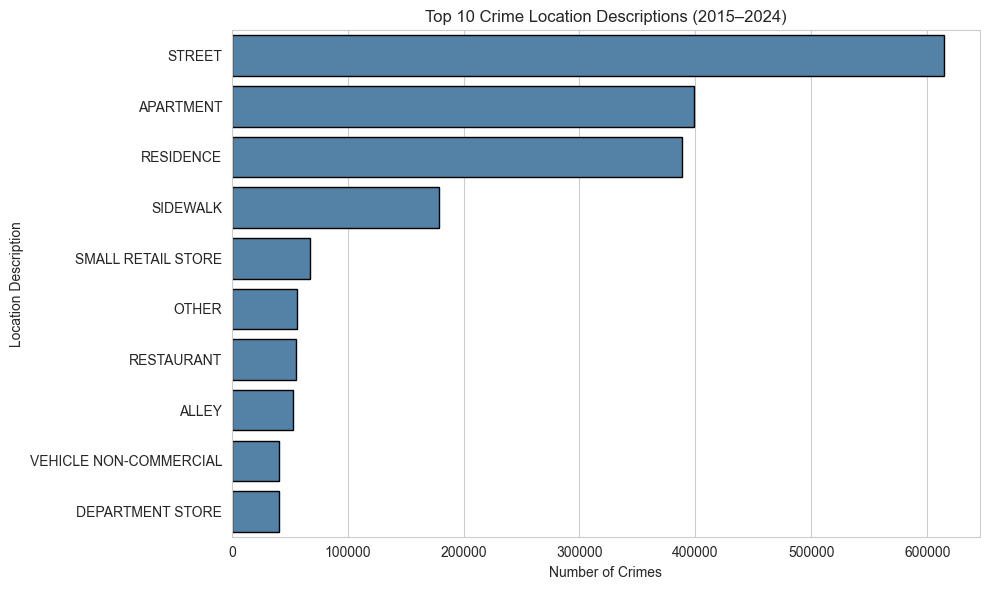

In [9]:
top_locations = crime_df['Location Description'].value_counts().head(10)

# Wrap long labels to improve readability
wrapped_labels = [
    textwrap.fill(str(label), width=22) for label in top_locations.index
]

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=top_locations.values,
    y=wrapped_labels,
    color='steelblue',
    edgecolor='black',
    linewidth=1.0
)
ax.set_title('Top 10 Crime Location Descriptions (2015–2024)')
ax.set_xlabel('Number of Crimes')
ax.set_ylabel('Location Description')
plt.tight_layout()
plt.show()


# Section C: Deep Dive Insights
We explore the most impacted communities and compare domestic vs. non-domestic incidents.

## Plot 5: Top 10 Communities by Crime Count
This chart surfaces communities with the highest crime volume for priority interventions.

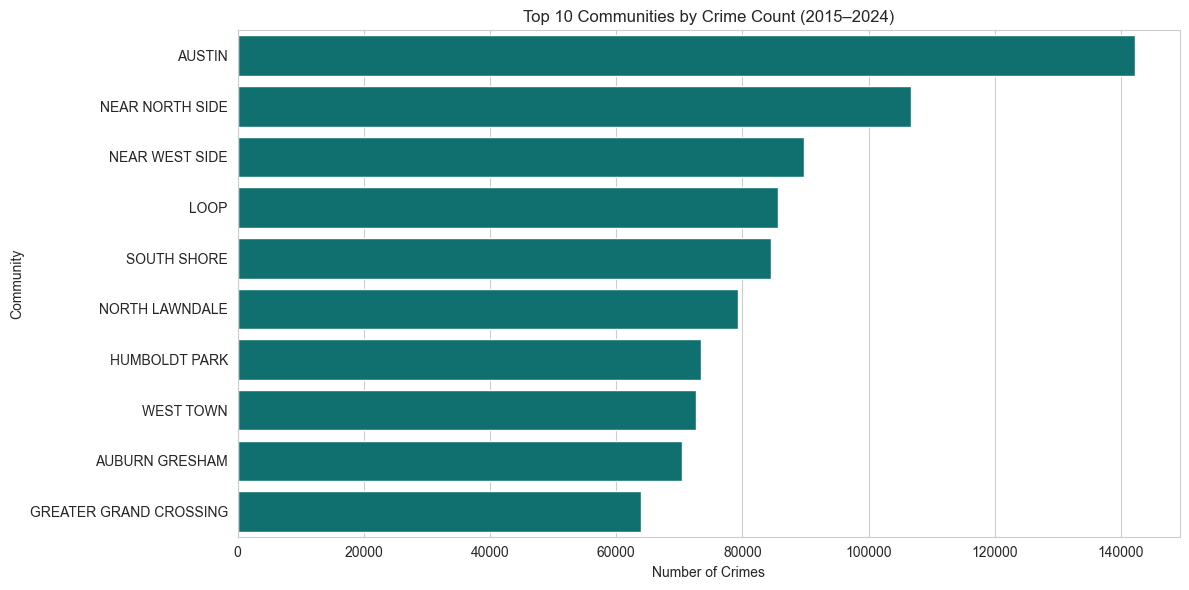

In [10]:
top_communities = crime_df['Community_Name'].value_counts().head(10)

plt.figure()
sns.barplot(x=top_communities.values, y=top_communities.index, color='teal')
plt.title('Top 10 Communities by Crime Count (2015–2024)')
plt.xlabel('Number of Crimes')
plt.ylabel('Community')
plt.tight_layout()
plt.show()


## Plot 6: Domestic vs Non-Domestic Crimes
This pie chart compares domestic and non-domestic incidents to inform specialized prevention programs.

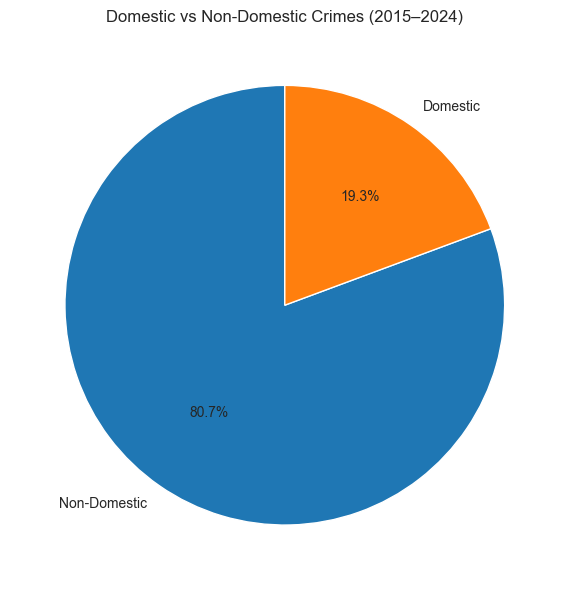

In [11]:
domestic_counts = crime_df['Domestic'].value_counts()

values = [domestic_counts.get(False, 0), domestic_counts.get(True, 0)]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=['Non-Domestic', 'Domestic'], autopct='%1.1f%%', startangle=90)
plt.title('Domestic vs Non-Domestic Crimes (2015–2024)')
plt.tight_layout()
plt.show()


# Section D: District Specialization Analysis

## Plot 1: Specialized Analysis of Crime Composition in Police Districts

Show the proportion of various crime types within each police district.


<Figure size 1500x800 with 0 Axes>

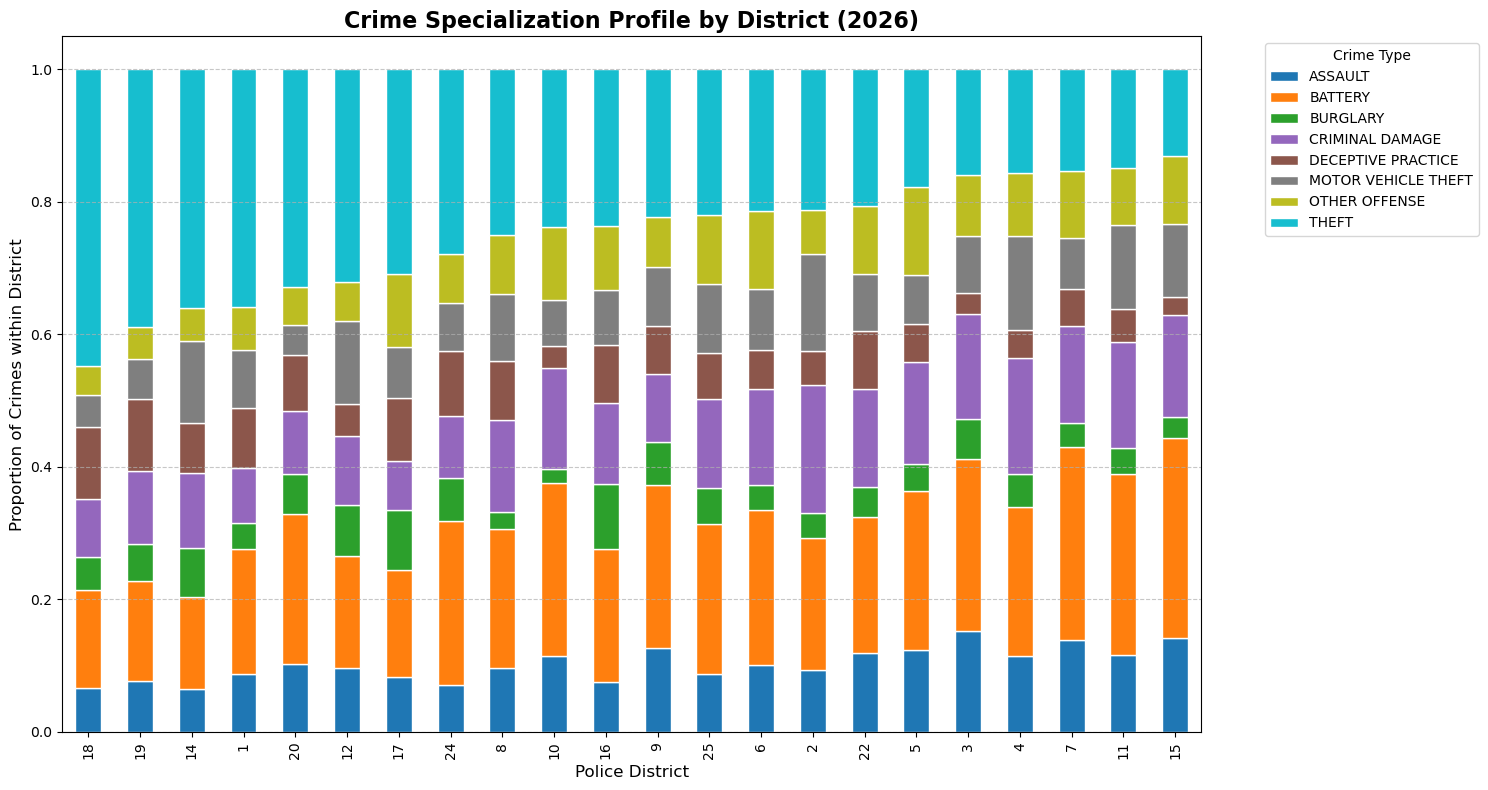

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('C:\\Users\\LENOVO\\Downloads\\Crimes_-_2026_20260209.csv')

top_crime_types = df['Primary Type'].value_counts().nlargest(8).index
df_filtered = df[df['Primary Type'].isin(top_crime_types)]


district_crime_counts = pd.crosstab(df_filtered['District'], df_filtered['Primary Type'])

district_crime_pct = district_crime_counts.div(district_crime_counts.sum(axis=1), axis=0)


district_crime_pct = district_crime_pct.sort_values(by='THEFT', ascending=False)
plt.figure(figsize=(15, 8))
district_crime_pct.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab10', edgecolor='white')

plt.title('Crime Specialization Profile by District (2026)', fontsize=16, fontweight='bold')
plt.ylabel('Proportion of Crimes within District', fontsize=12)
plt.xlabel('Police District', fontsize=12)
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('district_specialization_stacked_bar.png')
plt.show()

In [ ]:
## Plot 2: Z-Score Anomaly Identification

The Z-Score measures the extent to which a particular crime ratio in a police district deviates from the city average.

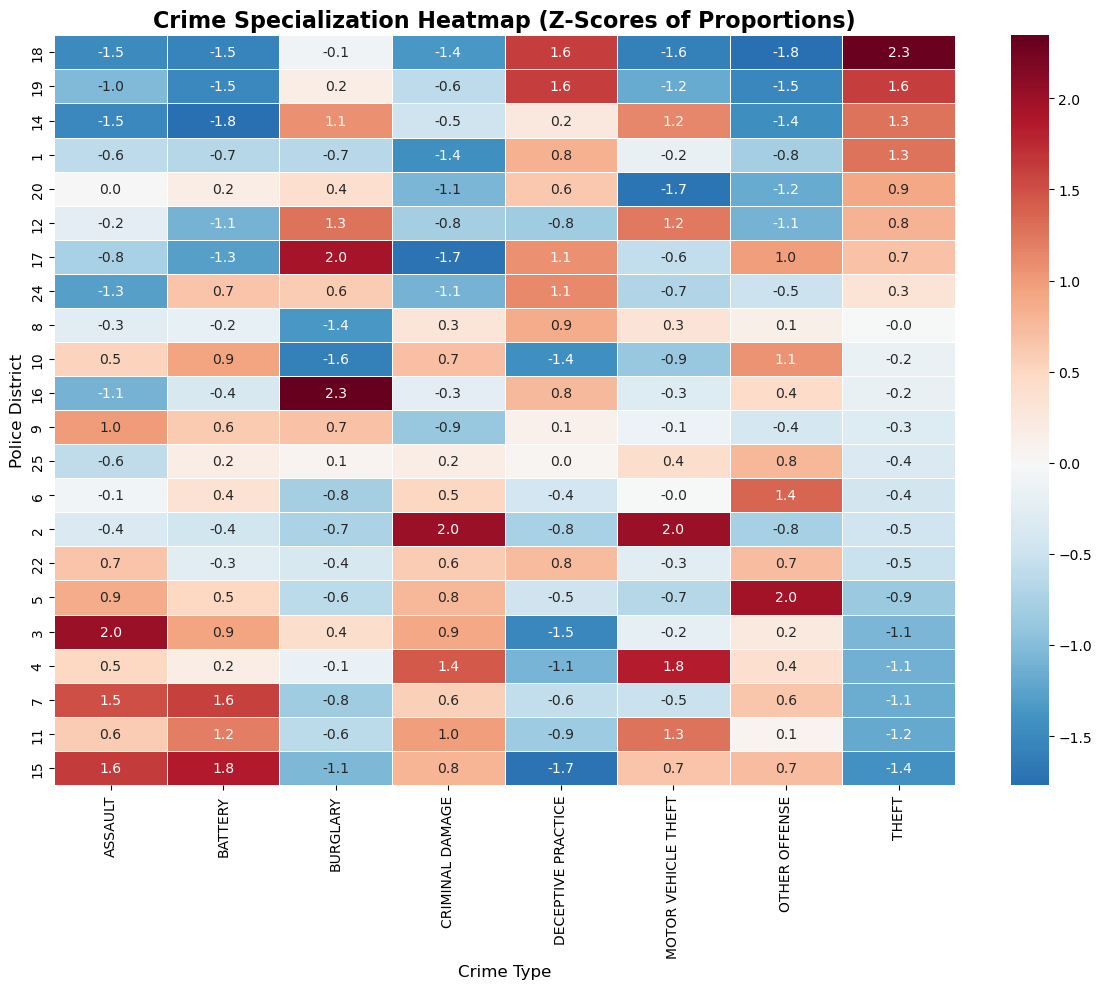

--- report---

Top 3 districts with the highest proportion of theft (THEFT).:
District
18    0.448320
19    0.389140
14    0.360308
Name: THEFT, dtype: float64

The top 3 districts with the highest proportion of violent assault (BATTERY).:
District
15    0.301471
7     0.290076
11    0.272120
Name: BATTERY, dtype: float64


In [4]:
district_zscore = district_crime_pct.apply(zscore)

plt.figure(figsize=(12, 10))
sns.heatmap(district_zscore, 
            annot=True,       
            fmt=".1f",        
            cmap='RdBu_r',    
            center=0,         
            linewidths=.5)

plt.title('Crime Specialization Heatmap (Z-Scores of Proportions)', fontsize=16, fontweight='bold')
plt.ylabel('Police District', fontsize=12)
plt.xlabel('Crime Type', fontsize=12)
plt.tight_layout()
plt.savefig('district_specialization_heatmap_zscore.png')
plt.show()

print("--- report---")
print("\nTop 3 districts with the highest proportion of theft (THEFT).:")
print(district_crime_pct['THEFT'].head(3))

print("\nThe top 3 districts with the highest proportion of violent assault (BATTERY).:")
print(district_crime_pct['BATTERY'].sort_values(ascending=False).head(3))

In [ ]:
# Section E: Enforcement & Outcome Correlation

In [ ]:
## Plot 1: SArrest Rate by Location Type

Calculate the average arrest rate for the top 15 high-frequency crime locations.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26640\3173990834.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_arrest.values, y=location_arrest.index, palette='magma')


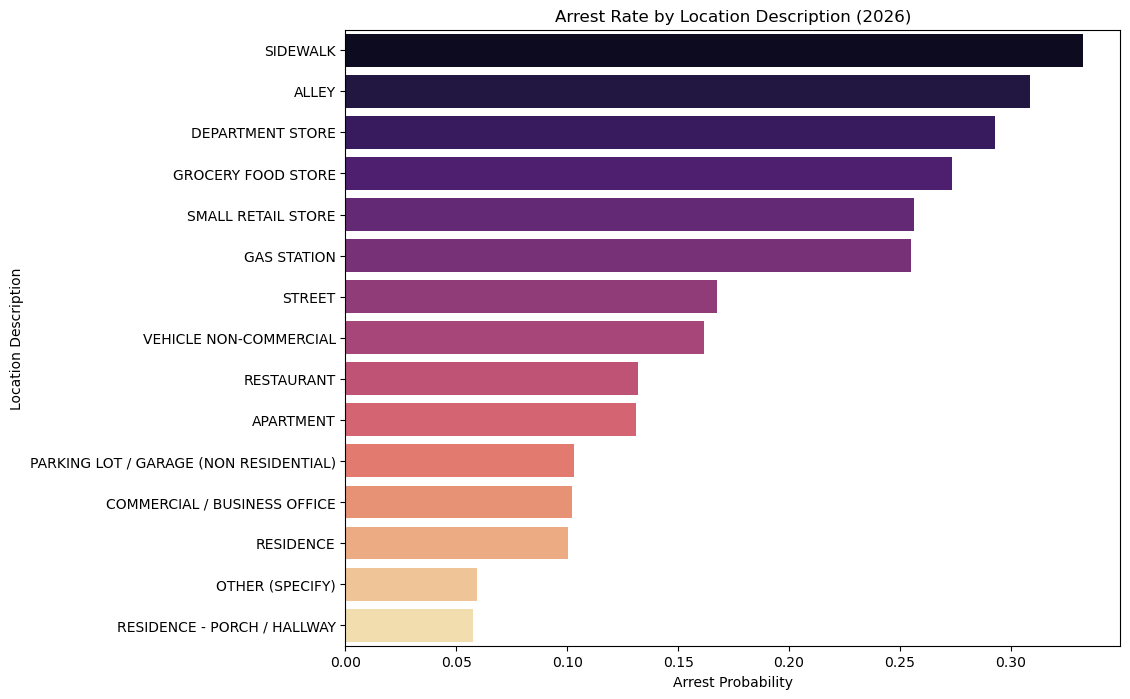

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. 计算不同地点的逮捕率
top_locations = df['Location Description'].value_counts().nlargest(15).index
location_arrest = df[df['Location Description'].isin(top_locations)].groupby('Location Description')['Arrest'].mean().sort_values(ascending=False)

# 2. 绘制案发地点逮捕率排行图
plt.figure(figsize=(10, 8))
sns.barplot(x=location_arrest.values, y=location_arrest.index, palette='magma')
plt.title('Arrest Rate by Location Description (2026)')
plt.xlabel('Arrest Probability')
plt.savefig('location_arrest_rate.png')

In [ ]:
## Plot 2: Crime-Location Arrest Heatmap
Cross-arrest heat map of location and crime type

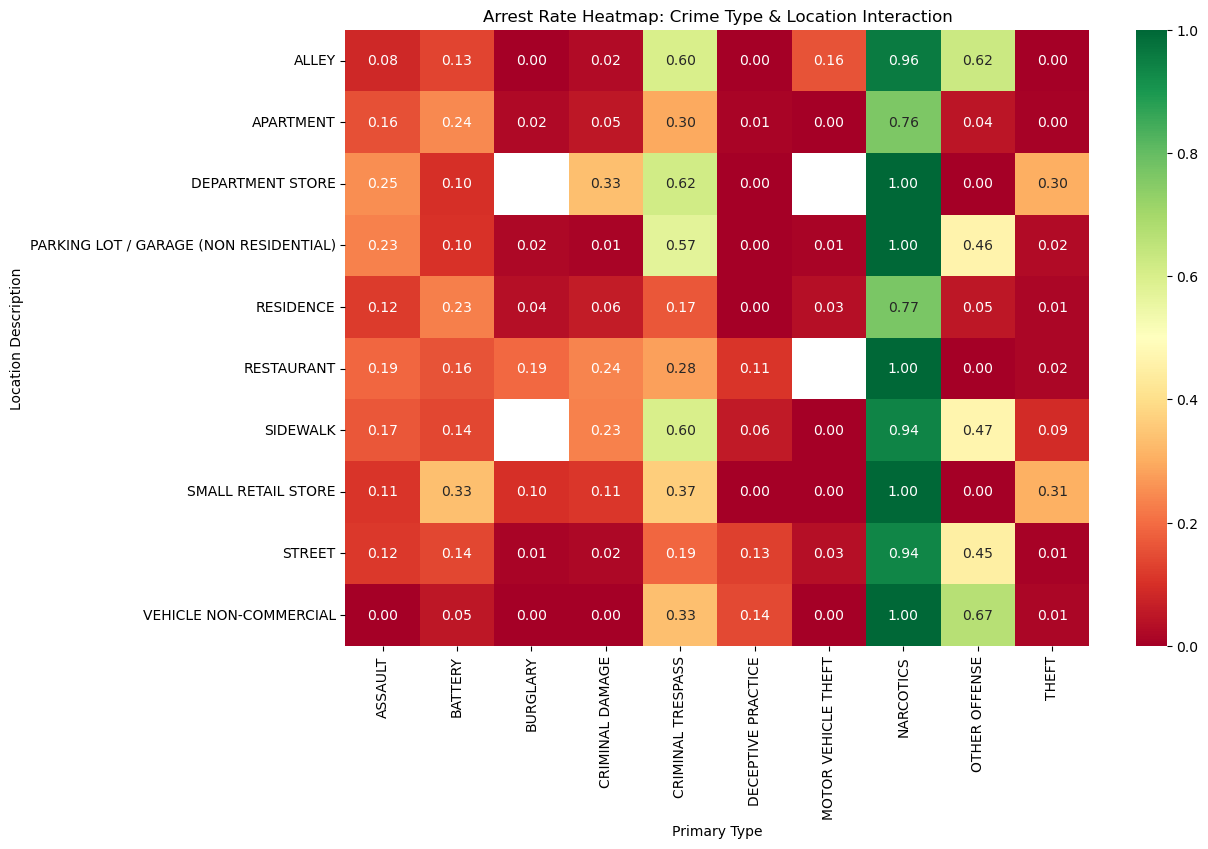

In [10]:
top_crimes = df['Primary Type'].value_counts().nlargest(10).index
pivot_arrest = df[df['Primary Type'].isin(top_crimes) & df['Location Description'].isin(top_locations[:10])]
pivot_arrest = pivot_arrest.groupby(['Location Description', 'Primary Type'])['Arrest'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_arrest, annot=True, fmt=".2f", cmap='RdYlGn', center=0.5)
plt.title('Arrest Rate Heatmap: Crime Type & Location Interaction')
plt.savefig('location_crime_arrest_heatmap.png')

## 6. Save Enriched Data
We save the cleaned and enriched dataset for downstream modeling and analysis.

In [12]:
OUTPUT_PATH = 'chicago_crime_2015_2024_enriched.parquet'
crime_df.to_parquet(OUTPUT_PATH, index=False)
print(f'Saved enriched data to {OUTPUT_PATH}')


Saved enriched data to chicago_crime_2015_2024_enriched.parquet
